# **User Retention Analysis: Cohort Analysis Method**
**Author:** Muhammad syafii Assubki
**Date:** 06/02/2026

## **Project Objective**
The goal of this project is to analyze user retention behavior using **Cohort Analysis**. By grouping users based on their acquisition month, we aim to understand:
1. **User Retention Rate:** How many users return to purchase in subsequent months?
2. **Cohort Size Stability:** How is the acquisition of new users trending over time?

The analysis focuses on distinguishing between **Transactional Volume** (Cohort Size) and **Loyalty** (Retention Percentage) to provide a holistic view of business health.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### **1. Data Cleaning & Preparation (ETL)**
Raw data often contains noise that can skew retention metrics. In this step, we perform strict filtering:
* **Format Correction:** Converting `order_date` to datetime objects.
* **ID Validation:** Removing transactions with missing `customer_id` (anonymous users cannot be tracked).
* **Transaction Filtering:** Removing cancelled orders (prefixed with 'C') and test transactions.
* **Sanity Check:** Ensuring quantity is positive.

In [ ]:
def load_data(filepath):
    """Loads CSV data with error handling."""
    try:
        print("Loading data...")
        df = pd.read_csv(filepath, header=0)
        print(f"Data loaded! Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("File not found. Check path.")
        return None

def clean_data(df):
    """Removes nulls, cancelled orders, and test products."""
    print("\nCleaning data...")
    original_size = df.shape[0]
    df_clean = df.copy()

    
    df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])
    df_clean = df_clean.dropna(subset=['customer_id'])

    df_clean = df_clean[~df_clean['order_id'].astype(str).str.startswith('C')]
    df_clean = df_clean[~df_clean['product_code'].astype(str).str.contains('TEST')]
    df_clean = df_clean[df_clean['quantity'] > 0]

    df_clean['customer_id'] = df_clean['customer_id'].astype(int).astype(str)

    cleaned_size = df_clean.shape[0]
    print(f"Data Cleaned! Removed {original_size - cleaned_size} rows.")
    print(f"Valid rows: {cleaned_size}")
    
    return df_clean

### **2. Constructing the Cohort Matrix**
We group users based on their **Acquisition Month** (Cohort Month) and track their activity over subsequent months (Cohort Index).

* **Cohort Month:** The month a user made their first-ever purchase.
* **Cohort Index:** The number of months passed since the first purchase (Start month = 1).

In [ ]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

def get_cohort_matrix(df):
    print("\nProcessing Cohort Logic...")
    df['invoice_month'] = df['order_date'].apply(get_month)
    
    grouping = df.groupby('customer_id')['invoice_month']
    df['cohort_month'] = grouping.transform('min')
    
    def get_date_int(df, column):
        year = df[column].dt.year
        month = df[column].dt.month
        return year, month

    invoice_year, invoice_month = get_date_int(df, 'invoice_month')
    cohort_year, cohort_month = get_date_int(df, 'cohort_month')

    diff_year = invoice_year - cohort_year
    diff_month = invoice_month - cohort_month

    df['cohort_index'] = (diff_year * 12) + diff_month + 1
    cohort_data = df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
    cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')
    
    print("Cohort Matrix Created!")
    return cohort_counts

### **3. Visualization: Dual-Panel Heatmap**
To avoid the "percentage trap," we visualize two aspects side-by-side:
1.  **Cohort Size (Left Panel):** The absolute number of new users acquired per month. This provides context on volume.
2.  **Retention Rate (Right Panel):** The percentage of those users who returned. This indicates loyalty/product fit.

Loading data...
Data loaded! Shape: (461773, 7)

Cleaning data...
Data Cleaned! Removed 108867 rows.
Valid rows: 352906

Processing Cohort Logic...
Cohort Matrix Created!

Generating Dual-Panel Visualization...


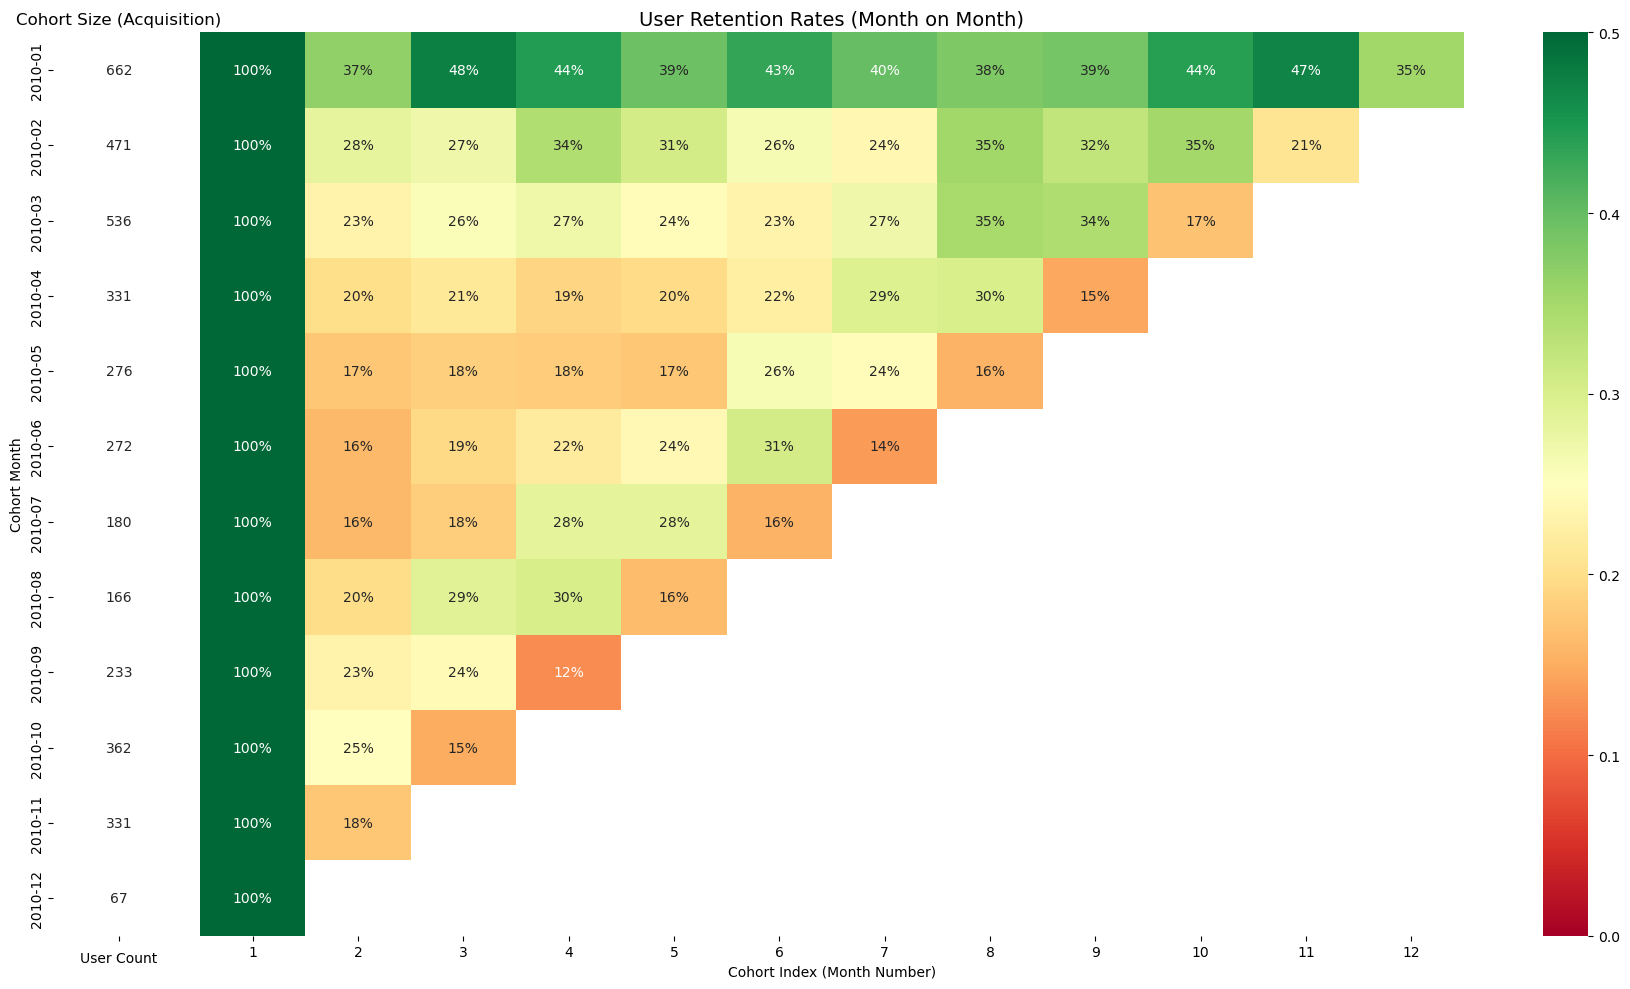

In [ ]:
def visualize_cohort(cohort_counts):
    print("\nGenerating Dual-Panel Visualization...")
    
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.index = retention.index.strftime('%Y-%m')
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [1, 12]})
    cohort_size_df = pd.DataFrame(cohort_sizes).set_index(retention.index)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].set_title('Cohort Size (Acquisition)', fontsize=12)
    ax[0].set(xlabel='User Count', ylabel='Cohort Month', xticklabels=[])
    
    sns.heatmap(retention, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0.0, vmax=0.5, ax=ax[1])
    ax[1].set_title('User Retention Rates (Month on Month)', fontsize=14)
    ax[1].set(xlabel='Cohort Index (Month Number)', ylabel='')
    ax[1].set_yticks([]) 
    
    plt.tight_layout()
    plt.show()

file_path = 'Online Retail Data.csv' 
df = load_data(file_path)

if df is not None:
    df_clean = clean_data(df)
    cohort_counts = get_cohort_matrix(df_clean)
    visualize_cohort(cohort_counts)

### **4. Business Insights & Conclusion**

Based on the Cohort Analysis above, we can draw two critical conclusions:

1.  **Retention Rate (Quality):**
    The user retention rate is healthy. For the Jan-2010 cohort, **~35% of users** are still transacting after 12 months. The consistent green shades in the right panel indicate strong product-market fit and customer loyalty for established users.

2.  **Acquisition Trend (Quantity):**
    The left panel (Cohort Size) reveals a worrying trend. The number of new acquired users has **dropped significantly** from ~600 in January to <70 in December.

**Recommendation:**
While the product retains users well (good defense), the business is failing to attract new users (weak offense). Marketing efforts need to be revitalized to boost the top-of-funnel acquisition, as the current organic growth is decelerating.